In [1]:
import base64
import numpy as np
import cv2
import os
import json
import requests
import mimetypes
from matplotlib import pyplot as plt

# Generate OCR visualizations with categorization from preprocessor
This presupposes that the preprocessor is running on 0.0.0.0:6201. If not, change the URL in the cell below.

In [2]:
def rgb_to_grayscale(rgb_image):
    """
    Converts a cv2 RGB image to grayscale.
    """
    gray_img = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    return gray_img

def convert_bytestring_to_cv2(bytestring):
    """
    Converts an image bytestring to a cv2 image
    :param bytestring: bytestring of an image file
    :return: np array
    """
    arr = np.frombuffer(base64.b64decode(bytestring), dtype=np.uint8)
    return cv2.imdecode(arr, flags=1)

def send_request_to_preprocessor(resource, content=None, type="post"):
    """
    Sends request preprocessor resource and returns response json. If return status code is not 200, will return
    dictionary with key "ERROR".
    :param resource: the REST resource to be called, e.g. /drawing/get/1 (include leading /)
    :param content: the payload of the request, e.g. json data for saving a drawing
    :param type: post, get, or delete
    :return: json response from endpoint
    """
    url = "0.0.0.0:6201" + resource
    return send_request_to(url, content, type)


def send_request_to(url, content, type="post"):
    """
    Sends request to url and returns response json. If return status code is not 200, will return dictionary with key
    "ERROR".
    :param url: url to sent content to
    :param content: content to sent to url
    :param type: post, get, or delete
    :return: json response from endpoint
    """
    try:
        if type == "get":
            response = requests.get(url, json=content, timeout=100)  # timeout of 100 seconds
        elif type == "post":
            response = requests.post(url, json=content, timeout=100)
        elif type == "delete":
            response = requests.delete(url, timeout=100)
        else:
            return {"ERROR": "invalid request type"}
    except requests.exceptions.Timeout:
        return {"ERROR": "timed out"}
    if response.status_code == 200 or response.status_code == 201:
        if type == "get" or type == "post":
            return response.json()
        elif type == "delete":
            return True
        else:
            return None
    else:
        return {"ERROR": str(response.content)}

def get_vis_img(img, ocr_classes, ocr_bbs, ocr_text):
    draw_img = img.copy()

    possible_classes = ["material","general_tolerance","surface","gdt","thread","iso"]

    colors = [
        # -> material
        "f8961e", # light orange
        # -> general tol
        "f3722c", # orange
        # -> surface
        "43aa8b", # green
        # -> gdt
        "577590", # blue
        # -> thread
        "90be6d", # light green
        # -> iso
        "000000", # black
        # -> measure
        "f94144", # red
        # -> text
        "f9c74f", # yellow

    ]


    shapes = np.zeros_like(img)

    for bb, text, c in zip(ocr_bbs, ocr_text, ocr_classes, strict=True):
        [classification, is_text] = c
        if classification in possible_classes:
            color = colors[possible_classes.index(classification)]
        else:
            if is_text:
                color = colors[-1]
            else:
                color = colors[-2]

        shapes = cv2.rectangle(shapes, (bb[0], bb[1]), (bb[0] + bb[2], bb[1] + bb[3]), tuple(int(color[i:i+2], 16) for i in (0, 2, 4)), cv2.FILLED)

    alpha = 0.5
    mask = shapes.astype(bool)
    draw_img[mask] = cv2.addWeighted(img, alpha, shapes, 1 - alpha, 0)[mask]

    return draw_img


def get_rec_images(img, bbs):
    rec_imgs = []
    for bb in bbs:
        rec_imgs.append(img[bb[1]:bb[1]+bb[3], bb[0]:bb[0]+bb[2]])
    return rec_imgs

### Load Example File, Get Response

In [4]:
filename = "../../example_data/Schraubstutzen - Index b.pdf"
with open(os.path.join(filename), "rb") as f:
    file_bytes = f.read()
content_string = base64.b64encode(file_bytes).decode("utf-8")
content_type = mimetypes.guess_type(filename)[0]

file_data = {"file_name": filename, "file_content": content_string, "file_type": content_type}
response_data = send_request_to_preprocessor(resource="/image_to_vector", content=file_data, type="post")

### Plot Results

/tmp/ipykernel_38170/194318422.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


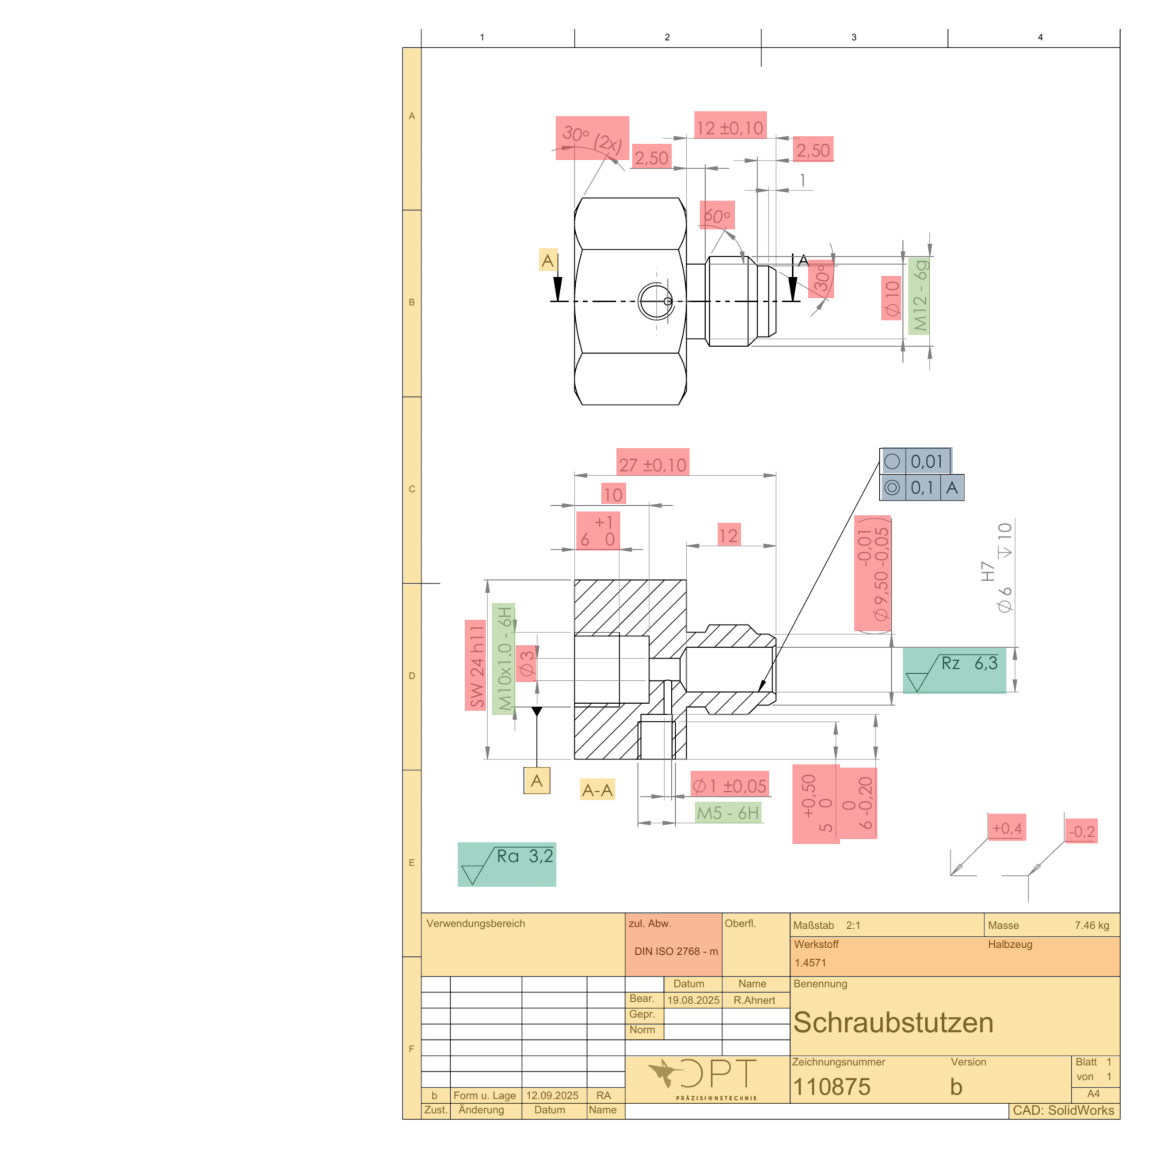

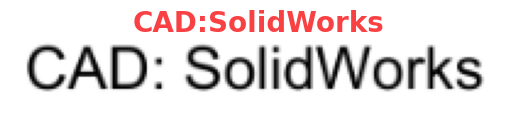

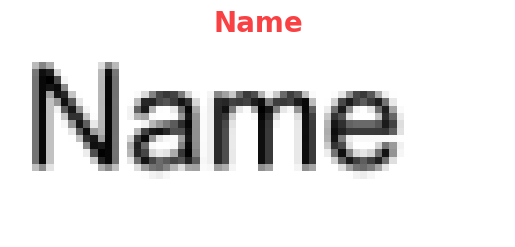

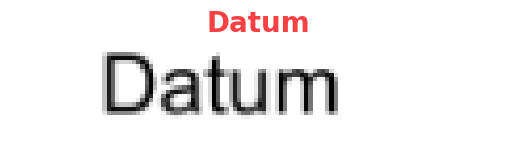

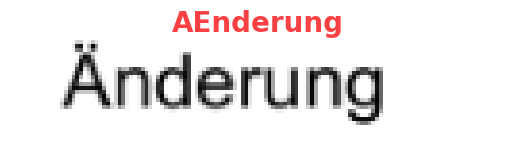

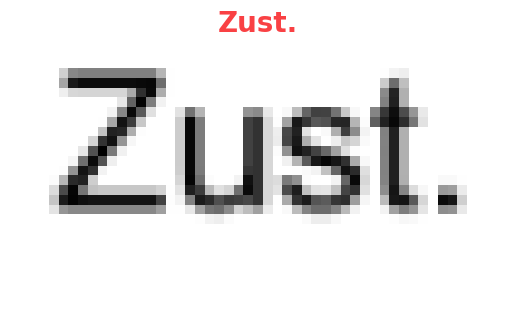

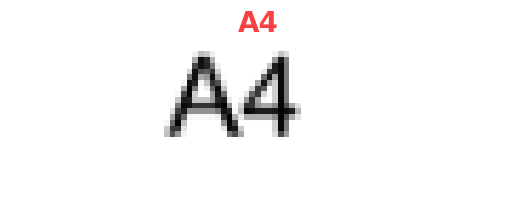

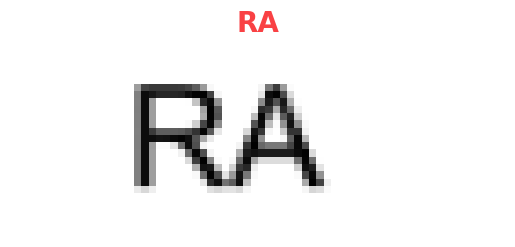

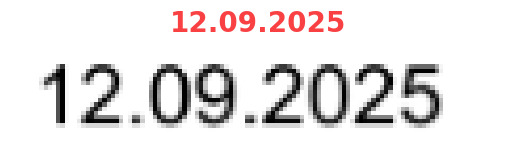

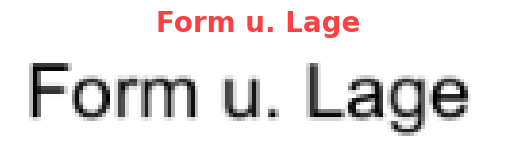

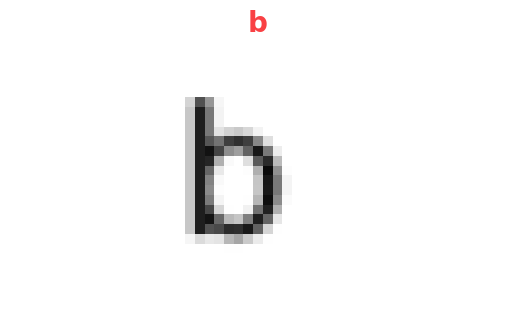

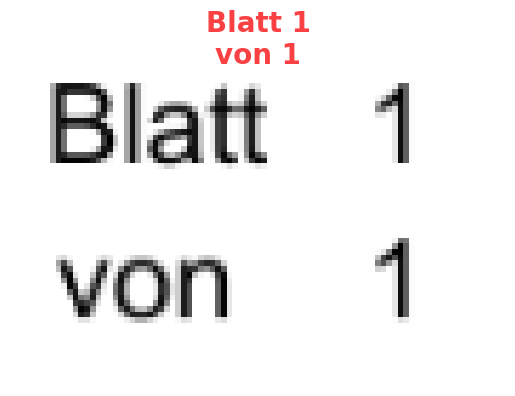

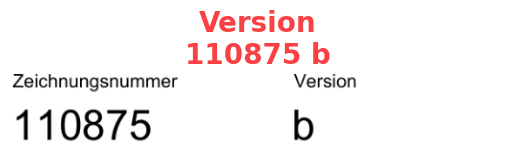

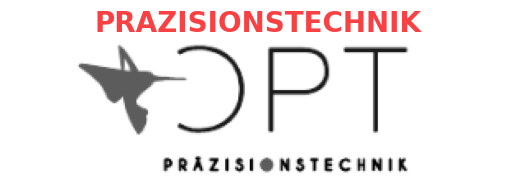

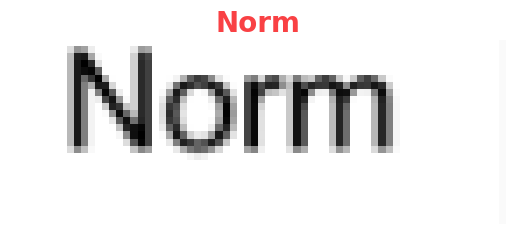

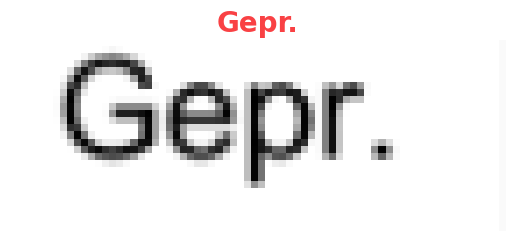

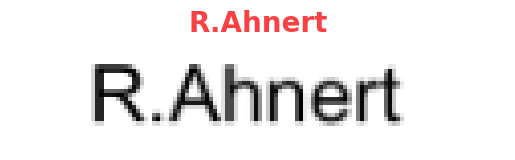

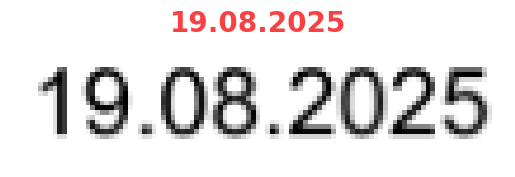

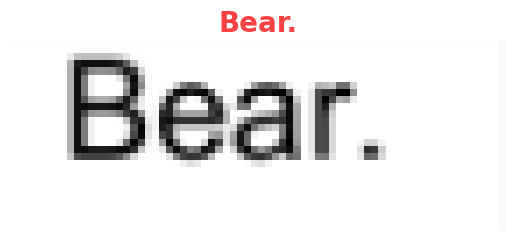

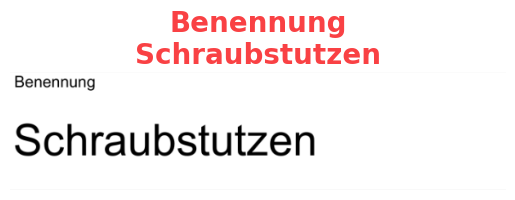

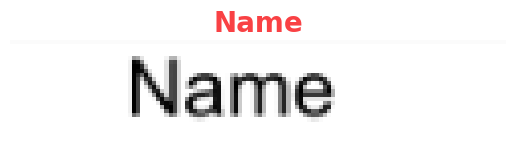

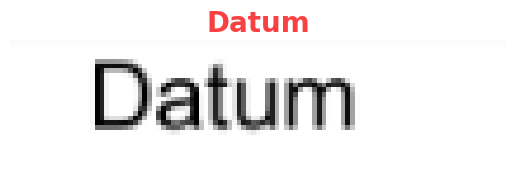

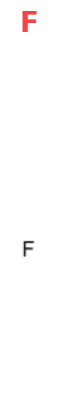

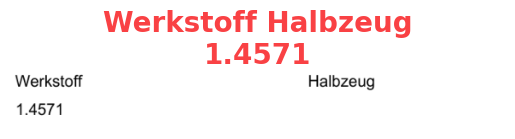

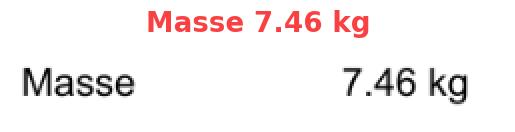

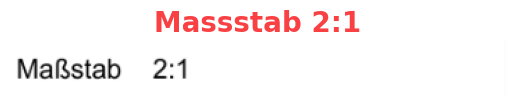

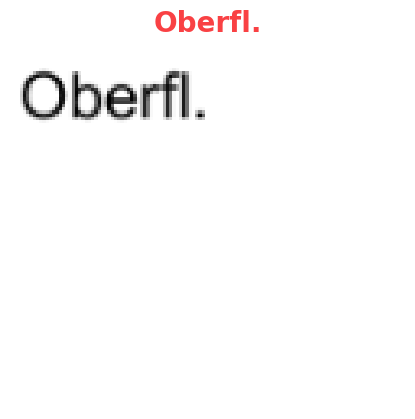

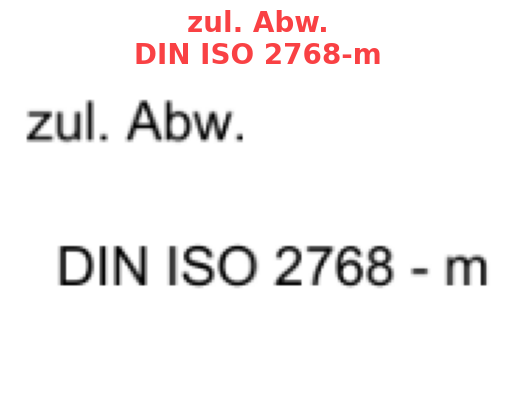

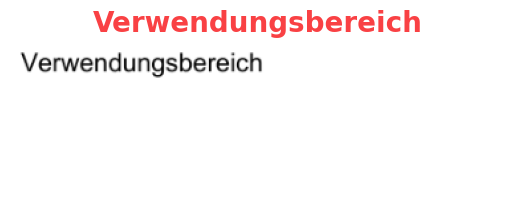

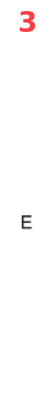

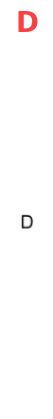

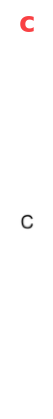

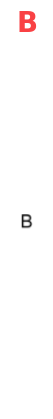

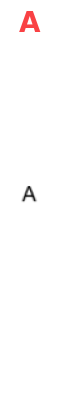

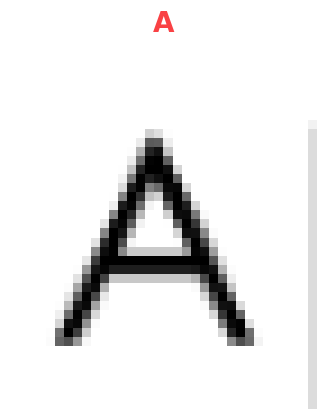

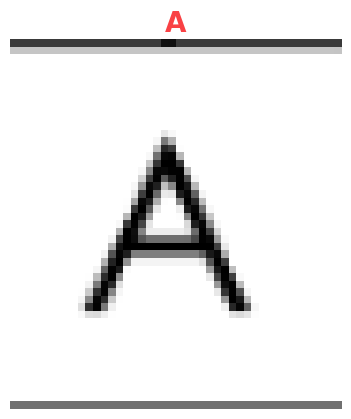

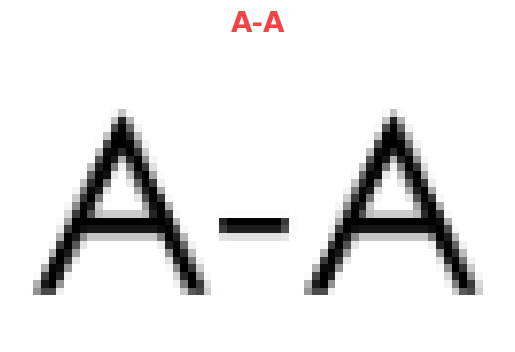

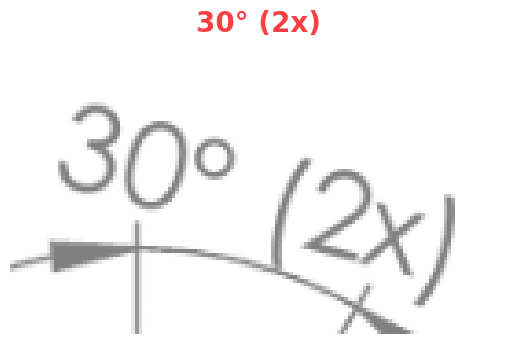

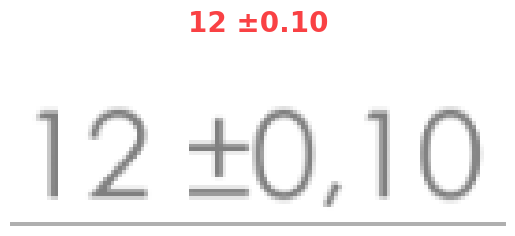

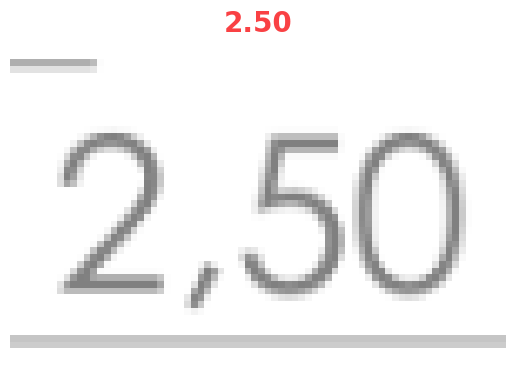

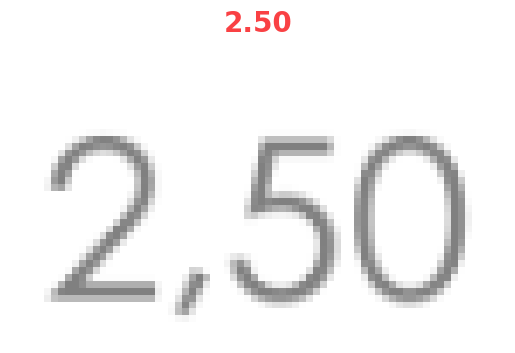

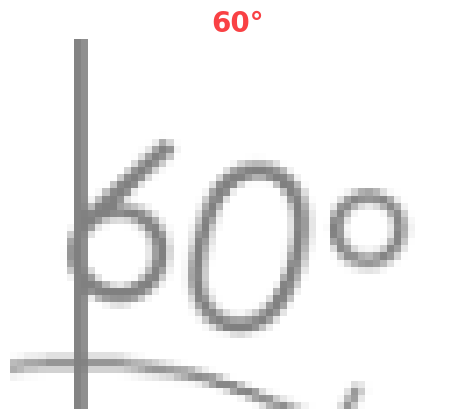

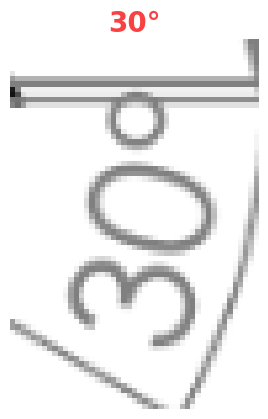

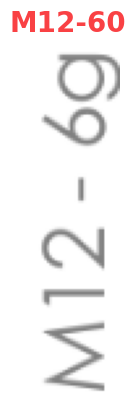

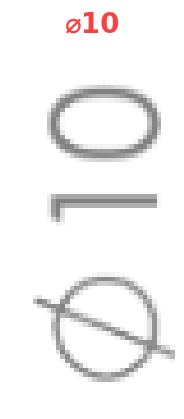

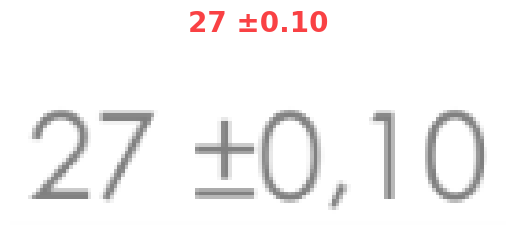

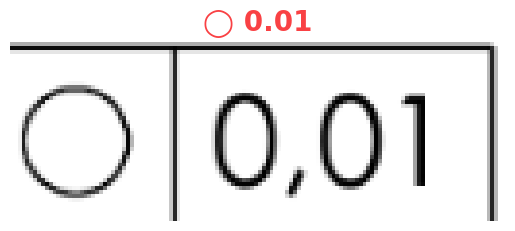

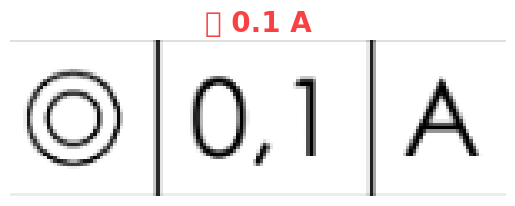

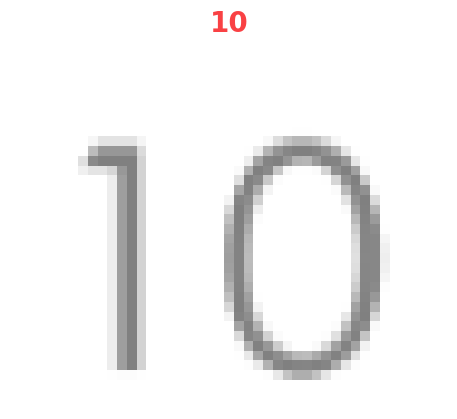

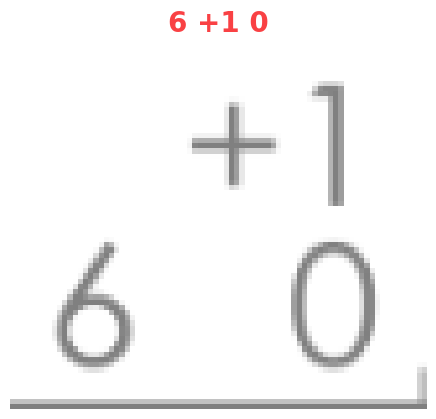

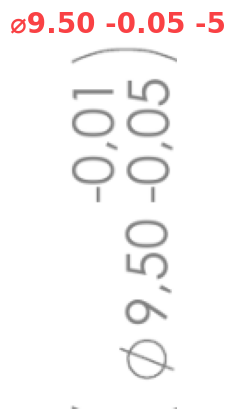

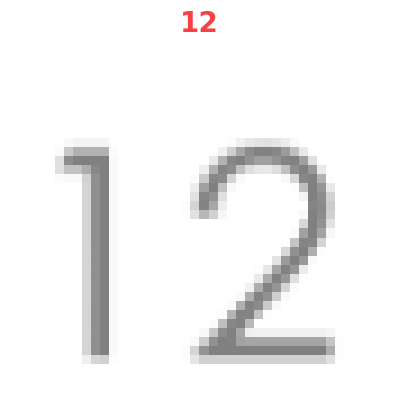

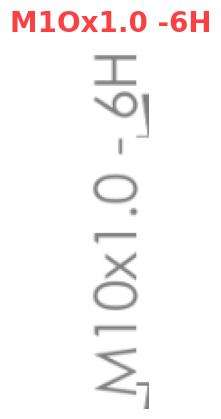

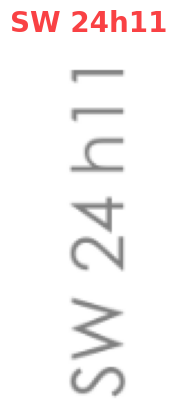

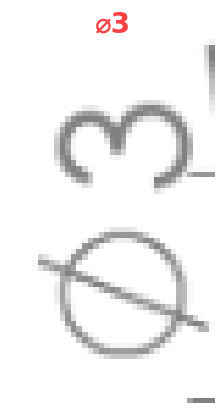

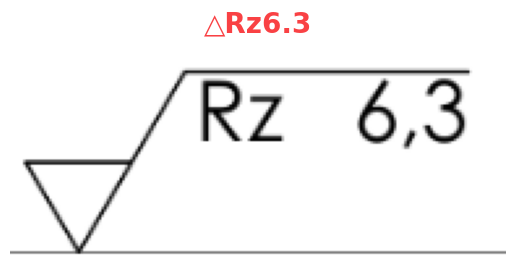

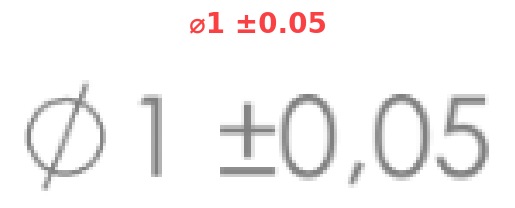

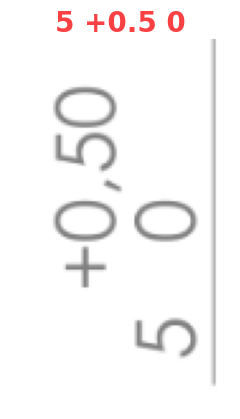

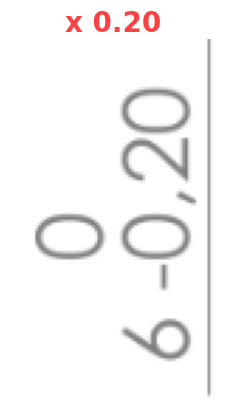

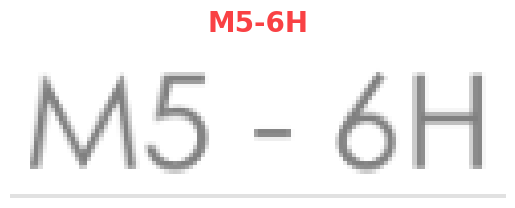

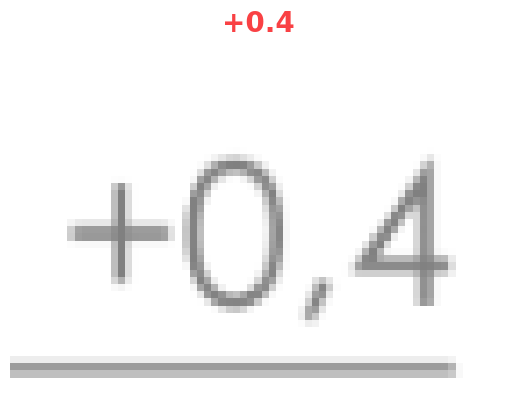

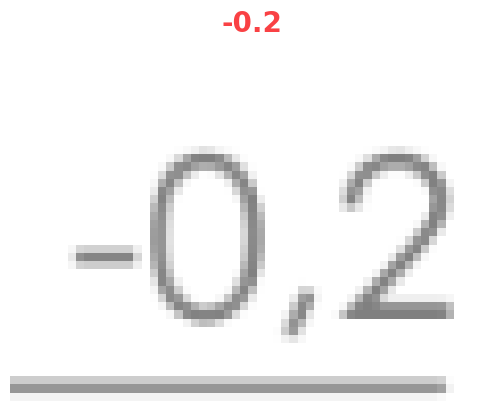

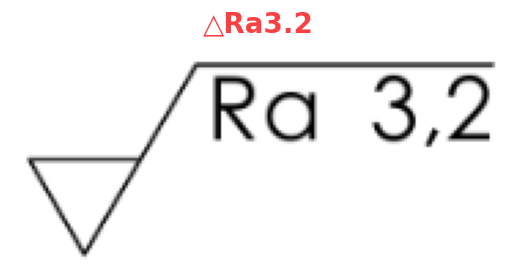

In [6]:
img_str = response_data["original_drawing"]
img = convert_bytestring_to_cv2(img_str)

ocr_classes = response_data["ocr_classes"]
ocr_bbs = response_data["ocr_bbs"]
ocr_text = response_data["ocr_text"]


plt.figure(dpi=300)
plt.axis('off')
plt.imshow(get_vis_img(img, ocr_classes, ocr_bbs, ocr_text))

rec_imgs = get_rec_images(img, ocr_bbs)

for rec_img, ocr_text in zip(rec_imgs, ocr_text):
    plt.figure()
    plt.title(ocr_text, fontsize=20, fontweight="bold", color="#f94144")
    plt.axis('off')
    plt.imshow(rec_img)